In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties as unc
plt.style.use('belle2')
#%jsroot on

#%run functins.ipynb

2024-08-24 20:04:27.689415: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 20:04:27.723275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 20:04:27.724391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 20:04:29.187227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0eepip4Streams.root"
#file_signal="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip200000.root"

file_rec_jpsi="/pnfs/desy.de/belle/local/user/msobotzi/jpsi/afterAcceptance/B0mumupip.root"
file_gen_jpsi="/pnfs/desy.de/belle/local/user/msobotzi/jpsi/afterPreCals/MC521_pip.root"


In [3]:
class trimVars():
    def trimCosTheta_L(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('abs(cosTheta_L) < 0.75')
            if q2 == 4:
                df = df.query('abs(cosTheta_L) < 0.95')
        
        if int(Btree) == 521:
            if pi == 'pip':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 ==4:
                    df = df.query('abs(cosTheta_L) < 0.95')
            if pi =='pi0':
                if q2 == 1:
                    df = df.query('abs(cosTheta_L) < 0.75')
                elif q2 !=4:
                    df = df.query('abs(cosTheta_L) < 0.9')
        return df

    
    def trimCosTheta_K(df, Btree, pi, ll, q2):
        if int(Btree) == 511:
            if q2 == 1:
                df = df.query('cosTheta_K > -0.9')
            elif q2 != 4:
                df = df.query('cosTheta_K > -0.9')
            else:
                df = df.query('abs(cosTheta_K) < 0.95')
                
        if int(Btree) == 521:
            if q2 == 1:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                else:
                    df = df.query('cosTheta_K > 0.9')
            elif q2 != 4:
                if pi == 'pip':
                    df = df.query('cosTheta_K > -0.9')
                elif pi == 'pi0':
                    df = df.query('cosTheta_K > -0.9')
                    
            elif q2 == 4:
                if pi == 'pip':
                    df = df.query('abs(cosTheta_K) > -0.95')
                if pi == 'pi0':
                    df = df.query('abs(cosTheta_K) < 0.9')
        return df
    
    def trimmers(df, Btree, pi, ll, q2):
        df = trimVars.trimCosTheta_L(df, Btree, pi, ll, q2)
        df = trimVars.trimCosTheta_K(df, Btree, pi, ll, q2)
        return df


In [4]:
def process_MC_data_combined(file_path_background, Btree, pi, ll, q2):
    def process_mc_data(file_path, Btree, pi, ll, q2):
        df = uproot.open(f"{file_path}:rec521").arrays(library='pd')
        mc_data_with_trim = trimVars.trimmers(df, Btree, pi, ll, q2)
        mc_data_without_trim = df
        
        return mc_data_with_trim, mc_data_without_trim

    mc_data_with_trim, mc_data_without_trim = process_mc_data(file_path_background, Btree, pi, ll, q2)
    
    def apply_cuts(mc_data, ll):
        if ll == 'ee':
            cut = "lm_genMotherPDG == 443 and lp_genMotherPDG == 443 and abs(Kst_genMotherPDG) == 521 and Kst_isSignal == 1 and abs(lm_PDG) == 11 and abs(lp_PDG) == 11 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        elif ll == 'mumu':
            cut = "lm_genMotherPDG == 443 and lp_genMotherPDG == 443 and abs(Kst_genMotherPDG) == 521 and Kst_isSignal == 1 and abs(lm_PDG) == 13 and abs(lp_PDG) == 13 and lm_genMotherPDG_1 == Kst_genMotherPDG"
        else:
            raise ValueError(f"Unknown ll: {ll}")
        
        deltaE_range = (-0.15, 0.15)
        
        mc_signal_q2cut_jpsi_kst_wot_filter = mc_data.query(cut)
        mc_signal_q2cut_jpsi_kst = mc_signal_q2cut_jpsi_kst_wot_filter[(mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] >= deltaE_range[0]) & (mc_signal_q2cut_jpsi_kst_wot_filter['deltaE'] <= deltaE_range[1])]
        
        return mc_signal_q2cut_jpsi_kst
    
    mc_signal_data_with_trim = apply_cuts(mc_data_with_trim, ll)
    mc_signal_data_without_trim = apply_cuts(mc_data_without_trim, ll)
    
    return mc_signal_data_with_trim, mc_signal_data_without_trim

# Example usage:
mc_mu_signal_data_with_trim, mc_mu_signal_data_without_trim = process_MC_data_combined(file_gen_jpsi, '521', 'pip', 'mumu', '11')


/cvmfs/belle.cern.ch/el9/externals/v02-00-02b/Linux_x86_64/common/lib/python3.8/site-packages/uproot/interpretation/library.py:806: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


In [5]:
import zfit
import tensorflow as tf
import pandas as pd
import numpy as np

class p5_prime_pdf(zfit.pdf.ZPDF):
    _N_OBS = 3  # dimension, can be omitted
    _PARAMS = ['param_fl','param_s3','param_p5']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x, y, z = x.unstack_x()  # x=costk, y=costl, z=phib
        param_fl = self.params['param_fl']
        param_s3 = self.params['param_s3']
        param_p5 = self.params['param_p5']
        
        return (9/(8*np.pi))*((3/4)*(1-param_fl)* (1-x**2) + param_fl * x**2 + \
               (1/4) *(1 - param_fl)* (1-x**2)* (2 * y**2 - 1)- \
               param_fl * x**2 * (2 * y**2 - 1) + param_s3 *(1-x**2)*(1-y**2) * tf.cos(2*z)+ \
               tf.sqrt(param_fl*(1-param_fl)) * param_p5 * 2*tf.sqrt(1-x**2) *x * tf.sqrt(1-y**2)* tf.cos(z))

def p5p_3D_fit(cost_k_data, cost_l_data, phi_b_data, param_fl_start, param_s3_start, param_p5_start, floating=True):
    # create space
    obs_cost_k = zfit.Space('cosTheta_K', limits=(min(cost_k_data), max(cost_k_data)))
    obs_cost_l = zfit.Space('cosTheta_L', limits=(min(cost_l_data), max(cost_l_data)))
    obs_phi_b = zfit.Space('phi_B', limits=(0, np.pi))
    obs = obs_cost_k * obs_cost_l * obs_phi_b

    # data
    df_sig = pd.concat([cost_k_data, cost_l_data, phi_b_data], axis=1)
    df_sig.columns = ['cosTheta_K', 'cosTheta_L', 'phi_B']  # Renaming columns to match observables
    data_fit_sig = zfit.Data.from_pandas(df_sig, obs=obs)

    # parameter variable
    r = np.round(np.random.rand(), decimals=8)

    # parameters
    param_fl = zfit.Parameter(f'param_fl_{r}', param_fl_start, floating=floating)
    param_s3 = zfit.Parameter(f'param_s3_{r}', param_s3_start, floating=floating)
    param_p5 = zfit.Parameter(f'param_p5_{r}', param_p5_start, floating=floating)

    extended = zfit.Parameter(f"extended_{r}", 10000)

    pdf_3D = p5_prime_pdf(param_fl=param_fl, param_s3=param_s3, param_p5=param_p5, obs=obs, extended=extended)
    pdf_3D.update_integration_options(max_draws=10000, tol=1e-4)  # Adjust parameters as needed

    # create NLL
    nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf_3D, data=data_fit_sig)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    if floating == True:
        result.hesse(name='hesse')

    print(result.params)
    print("Fit result valid:")
    print(result.valid)

    return pdf_3D

def fold_data(data):
    data['cosTheta_L'] = data['cosTheta_L'].abs()
    phi_b_gr = data.query(f"phi_B > {np.pi}")
    phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']
    phi_b_kl = data.query(f"phi_B <= {np.pi}")
    folded_data = pd.concat([phi_b_kl, phi_b_gr])
    return folded_data

mc_mu_signal_data_with_trim_fold = fold_data(mc_mu_signal_data_with_trim)

mc_mu_signal_data_with_trim_weight_fold=len(mc_mu_signal_data_with_trim_fold)

# Example usage with adjusted starting parameters
param_fl_start = 0.5  # Adjust based on your data 0.5
param_s3_start = 0.01  # Adjust based on your data -0.01
param_p5_start = 0.02  # Adjust based on your data 0.02

# Fit with phi_B greater than np.pi

pdf_fit_signal_with_trim_gr = p5p_3D_fit(mc_mu_signal_data_with_trim_fold["cosTheta_K"], mc_mu_signal_data_with_trim_fold["cosTheta_L"], mc_mu_signal_data_with_trim_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start,
                               floating=True)


# Now, let's print the total signal events again
print("Signal Events in MC Data =", mc_mu_signal_data_with_trim_weight_fold)


print("Without Trimmer")
mc_mu_signal_data_without_trim_fold = fold_data(mc_mu_signal_data_without_trim)

mc_mu_signal_data_without_trim_weight_fold=len(mc_mu_signal_data_without_trim_fold)

# Example usage without adjusted starting parameters
param_fl_start = 0.5  # Adjust based on your data 0.5
param_s3_start = 0.01  # Adjust based on your data -0.01
param_p5_start = 0.02  # Adjust based on your data 0.02

# Fit without phi_B greater than np.pi

pdf_fit_signal_without_trim_gr = p5p_3D_fit(mc_mu_signal_data_without_trim_fold["cosTheta_K"], mc_mu_signal_data_without_trim_fold["cosTheta_L"], mc_mu_signal_data_without_trim_fold["phi_B"],
                               param_fl_start, param_s3_start, param_p5_start,
                               floating=True)


# Now, let's print the total signal events again
print("Signal Events in MC Data =", mc_mu_signal_data_without_trim_weight_fold)


/tmp/ipykernel_3245483/2850076648.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.30676944             15237.5  +/- 1.2e+02       False
param_fl_0.30676944            0.565983  +/-  0.0058       False
param_s3_0.30676944           0.0880162  +/-  0.0077       False
param_p5_0.30676944           0.0114074  +/-   0.018       False
Fit result valid:
True
Signal Events in MC Data = 15237
Without Trimmer
name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
extended_0.85917587             16582.4  +/- 1.3e+02       False
param_fl_0.85917587            0.567323  +/-  0.0055       False
param_s3_0.85917587           0.0876424  +/-  0.0077       False
param_p5_0.85917587           0.0133677  +/-   0.018       False
Fit result valid:
True
Signal Events in MC Data = 16581


In [6]:
import numpy as np
from scipy.integrate import simps

# Define the ranges for integration
cosTheta_K_range_with_trim = np.linspace(-0.9, 1.0, 100)  # Range for cosTheta_K with trim
cosTheta_K_range_without_trim = np.linspace(-1.0, 1.0, 100)  # Range for cosTheta_K without trim
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

# Create grids for with trim
cosTheta_K_grid_with_trim, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
points_with_trim = np.vstack([cosTheta_K_grid_with_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

# Create grids for without trim
cosTheta_K_grid_without_trim, _, _ = np.meshgrid(cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)
points_without_trim = np.vstack([cosTheta_K_grid_without_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

# PDF values without trim
pdf_values_gr_without_trim = pdf_fit_signal_without_trim_gr.pdf(points_without_trim).numpy().reshape(cosTheta_K_grid_without_trim.shape)
integrated_pdf_total_without_trim = simps(simps(simps(pdf_values_gr_without_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_without_trim, axis=0)

# PDF values with trim
pdf_values_gr_with_trim = pdf_fit_signal_without_trim_gr.pdf(points_with_trim).numpy().reshape(cosTheta_K_grid_with_trim.shape)
integrated_pdf_total_with_trim = simps(simps(simps(pdf_values_gr_with_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1),  cosTheta_K_range_with_trim, axis=0)
    
# Print the integrated PDF
print(f"Integrated PDF with trim: {integrated_pdf_total_with_trim}")
print(f"Integrated PDF without trim: {integrated_pdf_total_without_trim}")


Integrated PDF with trim: 0.9202575552620562
Integrated PDF without trim: 1.000289923900042


area under the curve: 1.000184568423784
Total number of events: 15239.812269073196


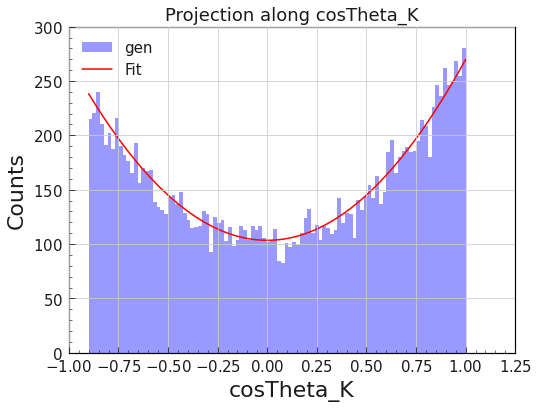

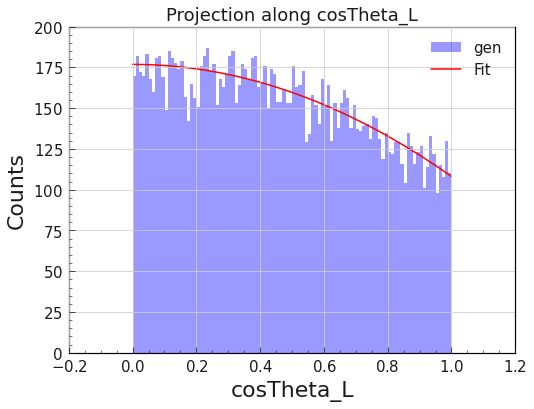

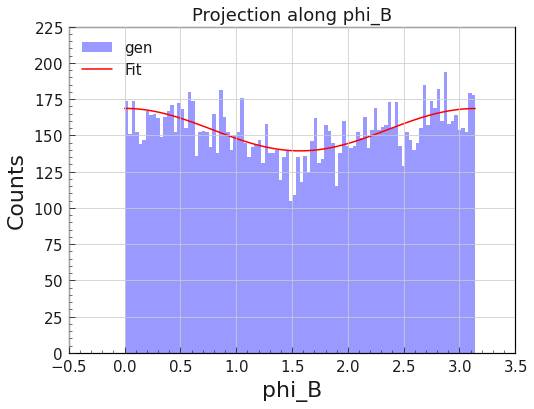

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

cosTheta_K_range = np.linspace(-0.9, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

cosTheta_K_grid, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)
points = np.vstack([cosTheta_K_grid.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

pdf_values_gr = pdf_fit_signal_with_trim_gr.pdf(points).numpy().reshape(cosTheta_K_grid.shape)

integrated_pdf_total = simps(simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
num_events_total = integrated_pdf_total * len(mc_mu_signal_data_with_trim_fold)

print("area under the curve:", integrated_pdf_total)
print("Total number of events:", num_events_total)

# Integration and normalization steps for cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1)
pdf_values_K = integrated_pdf_values_K * len(mc_mu_signal_data_with_trim_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_K_range, axis=0)
pdf_values_L = integrated_pdf_values_L * len(mc_mu_signal_data_with_trim_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_values_B = simps(simps(pdf_values_gr, cosTheta_K_range, axis=1), cosTheta_L_range, axis=0)
pdf_values_B = integrated_pdf_values_B * len(mc_mu_signal_data_with_trim_fold) * np.diff(phi_B_range)[0]


# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_signal_data_with_trim_fold["cosTheta_K"], bins=100, density=False, alpha=0.4, label='gen', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.xlabel('cosTheta_K')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_signal_data_with_trim_fold["cosTheta_L"], bins=100, density=False, alpha=0.4, label='gen', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_signal_data_with_trim_fold["phi_B"], bins=100, density=False, alpha=0.4, label='gen', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)
plt.show()


area under the curve: 1.000060313740616
Total number of events: 46498.80434768368


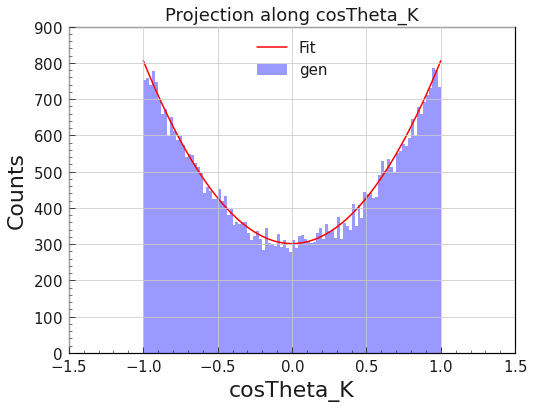

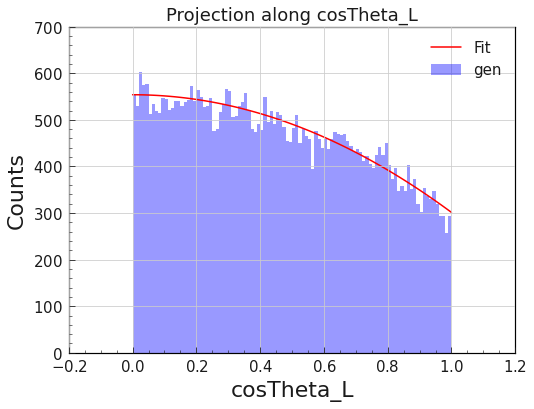

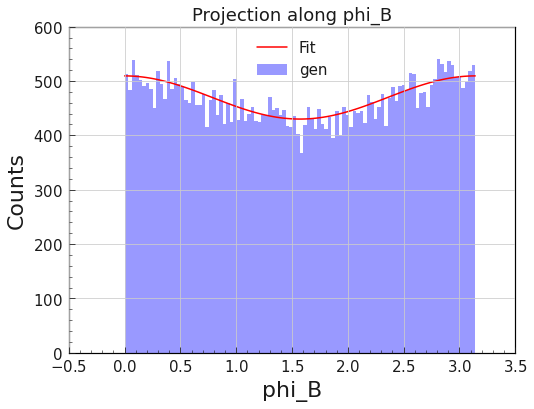

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import simps

cosTheta_K_range = np.linspace(-1.0, 1.0, 100)
cosTheta_L_range = np.linspace(0, 1.0, 100)
phi_B_range = np.linspace(0, np.pi, 100)

cosTheta_K_grid, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range, cosTheta_L_range, phi_B_range)
points = np.vstack([cosTheta_K_grid.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

pdf_values_gr = pdf_fit_signal_without_trim_gr.pdf(points).numpy().reshape(cosTheta_K_grid.shape)

integrated_pdf_total = simps(simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range, axis=0)
num_events_total = integrated_pdf_total * len(mc_mu_signal_data_without_trim_fold)

print("area under the curve:", integrated_pdf_total)
print("Total number of events:", num_events_total)

# Integration and normalization steps for cosTheta_K
integrated_pdf_values_K = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_L_range, axis=1)
pdf_values_K = integrated_pdf_values_K * len(mc_mu_signal_data_without_trim_fold) * np.diff(cosTheta_K_range)[0]

# Integration and normalization steps for cosTheta_L
integrated_pdf_values_L = simps(simps(pdf_values_gr, phi_B_range, axis=2), cosTheta_K_range, axis=0)
pdf_values_L = integrated_pdf_values_L * len(mc_mu_signal_data_without_trim_fold) * np.diff(cosTheta_L_range)[0]

# Integration and normalization steps for phi_B
integrated_pdf_values_B = simps(simps(pdf_values_gr, cosTheta_K_range, axis=1), cosTheta_L_range, axis=0)
pdf_values_B = integrated_pdf_values_B * len(mc_mu_signal_data_without_trim_fold) * np.diff(phi_B_range)[0]


# Plot results for cosTheta_K
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_signal_data_without_trim_fold["cosTheta_K"], bins=100, density=False, alpha=0.4, label='gen', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_K_range, pdf_values_L, 'r', label='Fit')
plt.xlabel('cosTheta_K')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_K')
plt.grid(True)

# Plot results for cosTheta_L
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_signal_data_without_trim_fold["cosTheta_L"], bins=100, density=False, alpha=0.4, label='gen', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(cosTheta_L_range, pdf_values_K, 'r', label='Fit')
plt.xlabel('cosTheta_L')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along cosTheta_L')
plt.grid(True)

# Plot results for phi_B
plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(mc_mu_signal_data_without_trim_fold["phi_B"], bins=100, density=False, alpha=0.4, label='gen', color='blue')
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(phi_B_range, pdf_values_B, 'r', label='Fit')
plt.xlabel('phi_B')
plt.ylabel('Counts')
plt.legend()
plt.title('Projection along phi_B')
plt.grid(True)
plt.show()


Integrated PDF with trim: 1.000184568423784
Integrated PDF without trim: 1.000289923900042
Proportion of data lost: 0.0001


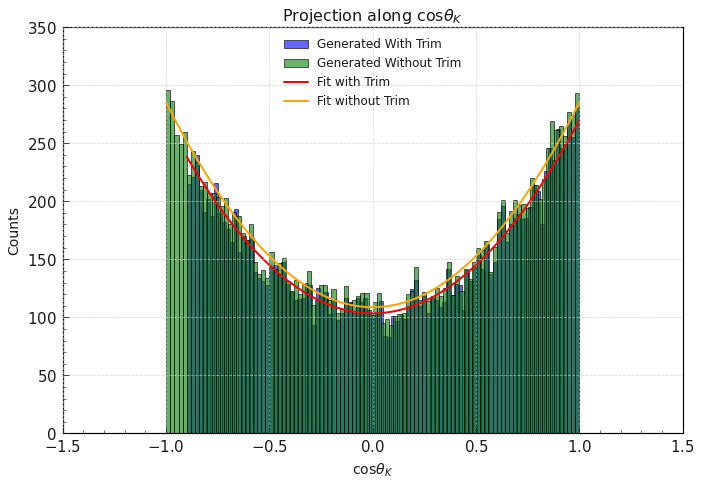

In [ ]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt

def process_and_plot(mc_mu_signal_data_with_trim_fold, mc_mu_signal_data_without_trim_fold, pdf_fit_signal_with_trim_gr, pdf_fit_signal_without_trim_gr):
    # Define ranges
    cosTheta_K_range_with_trim = np.linspace(-0.9, 1.0, 100)  # Range for cosTheta_K with trim
    cosTheta_K_range_without_trim = np.linspace(-1.0, 1.0, 100)  # Range for cosTheta_K without trim
    cosTheta_L_range = np.linspace(0, 1.0, 100)
    phi_B_range = np.linspace(0, np.pi, 100)

    # Create grids for with trim
    cosTheta_K_grid_with_trim, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    points_with_trim = np.vstack([cosTheta_K_grid_with_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

    # Create grids for without trim
    cosTheta_K_grid_without_trim, _, _ = np.meshgrid(cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)
    points_without_trim = np.vstack([cosTheta_K_grid_without_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

    # PDF values with trim
    pdf_values_gr_with_trim = pdf_fit_signal_with_trim_gr.pdf(points_with_trim).numpy().reshape(cosTheta_K_grid_with_trim.shape)
    integrated_pdf_total_with_trim = simps(simps(simps(pdf_values_gr_with_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_with_trim, axis=0)
    
    # PDF values without trim
    pdf_values_gr_without_trim = pdf_fit_signal_without_trim_gr.pdf(points_without_trim).numpy().reshape(cosTheta_K_grid_without_trim.shape)
    integrated_pdf_total_without_trim = simps(simps(simps(pdf_values_gr_without_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_without_trim, axis=0)
    
    # Calculate proportion of data lost
    proportion_data_lost = (integrated_pdf_total_without_trim - integrated_pdf_total_with_trim) / integrated_pdf_total_without_trim

    # Print the integrated PDF
    print(f"Integrated PDF with trim: {integrated_pdf_total_with_trim}")
    print(f"Integrated PDF without trim: {integrated_pdf_total_without_trim}")
    print(f"Proportion of data lost: {proportion_data_lost:.4f}")
    
    
    # Integration and normalization steps
    def integrate_and_normalize(pdf_values, num_events, cosTheta_K_range, cosTheta_L_range, phi_B_range):
        integrated_pdf_values_K = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_L_range, axis=1)
        pdf_values_K = integrated_pdf_values_K * num_events * np.diff(cosTheta_K_range)[0]

        integrated_pdf_values_L = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_K_range, axis=0)
        pdf_values_L = integrated_pdf_values_L * num_events * np.diff(cosTheta_L_range)[0]

        integrated_pdf_values_B = simps(simps(pdf_values, cosTheta_K_range, axis=1), cosTheta_L_range, axis=0)
        pdf_values_B = integrated_pdf_values_B * num_events * np.diff(phi_B_range)[0]

        return pdf_values_K, pdf_values_L, pdf_values_B

    pdf_values_K_with_trim, pdf_values_L_with_trim, pdf_values_B_with_trim = integrate_and_normalize(pdf_values_gr_with_trim, len(mc_mu_signal_data_with_trim_fold), cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    pdf_values_K_without_trim, pdf_values_L_without_trim, pdf_values_B_without_trim = integrate_and_normalize(pdf_values_gr_without_trim, len(mc_mu_signal_data_without_trim_fold), cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)

    # Plot results
    # Plot results
    def plot_histogram_with_fit(data_with_trim, data_without_trim, range_with_trim, range_without_trim, pdf_values_with_trim, pdf_values_without_trim, var_name):
        plt.figure(figsize=(10, 7))

        # Plot histograms
        n_with_trim, bins_with_trim, _ = plt.hist(data_with_trim, bins=100, density=False, alpha=0.6, label='Generated With Trim', color='blue', edgecolor='black')
        n_without_trim, bins_without_trim, _ = plt.hist(data_without_trim, bins=100, density=False, alpha=0.6, label='Generated Without Trim', color='green', edgecolor='black')

        # Plot fit lines
        plt.plot(range_with_trim, pdf_values_with_trim, color='red', lw=2, label='Fit with Trim')
        plt.plot(range_without_trim, pdf_values_without_trim, color='orange', lw=2, label='Fit without Trim')

        # Set axis labels and title
        plt.xlabel(var_name, fontsize=14)
        plt.ylabel('Counts', fontsize=14)
        plt.title(f'Projection along {var_name}', fontsize=16)

        # Add legend
        plt.legend(loc='best', fontsize=12)

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Improve layout
        plt.tight_layout()

        # Show plot
        plt.savefig(f'generat_JPsi_{var_name}_muon.pdf')
        plt.show()
        
    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["cosTheta_K"], mc_mu_signal_data_without_trim_fold["cosTheta_K"], cosTheta_K_range_with_trim, cosTheta_K_range_without_trim, pdf_values_L_with_trim, pdf_values_L_without_trim, 'cos$\\theta_K$')
    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["cosTheta_L"], mc_mu_signal_data_without_trim_fold["cosTheta_L"], cosTheta_L_range, cosTheta_L_range, pdf_values_K_with_trim, pdf_values_K_without_trim, 'cos$\\theta_L$')
    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["phi_B"], mc_mu_signal_data_without_trim_fold["phi_B"], phi_B_range, phi_B_range, pdf_values_B_with_trim, pdf_values_B_without_trim, '$\\phi_B$')


# Example usage with your data
# Ensure that `mc_mu_signal_data_with_trim_fold`, `mc_mu_signal_data_without_trim_fold`, `pdf_fit_signal_with_trim_gr`, and `pdf_fit_signal_without_trim_gr` are defined
process_and_plot(mc_mu_signal_data_with_trim_fold, mc_mu_signal_data_without_trim_fold, pdf_fit_signal_with_trim_gr, pdf_fit_signal_without_trim_gr)


Integrated PDF with trim: 1.0001063309742533
Integrated PDF without trim: 1.08779983611615
Proportion of data lost: 0.0806


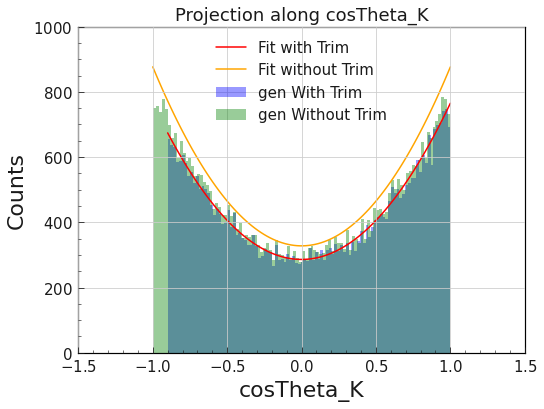

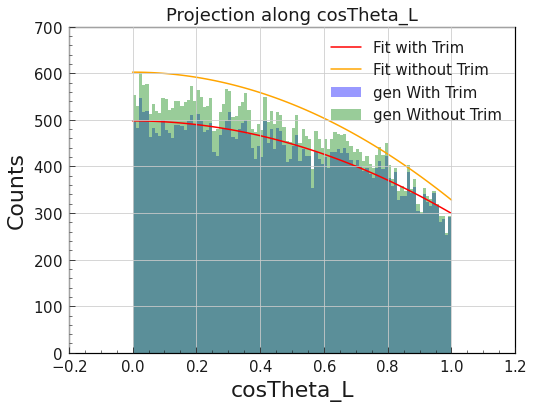

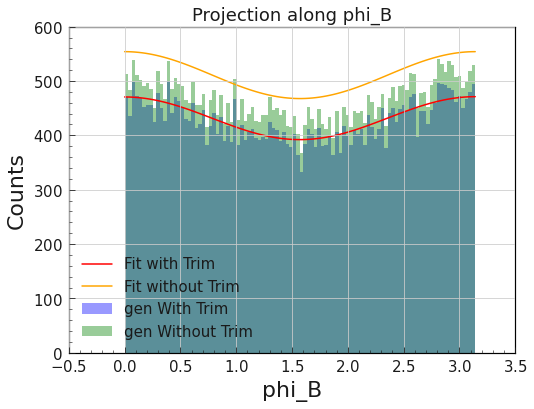

In [10]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt

def process_and_plot(mc_ele_signal_data_with_trim_fold, mc_ele_signal_data_without_trim_fold, pdf_fit_signal_with_trim_gr, pdf_fit_signal_without_trim_gr):
    # Define ranges
    cosTheta_K_range_with_trim = np.linspace(-0.9, 1.0, 100)  # Range for cosTheta_K with trim
    cosTheta_K_range_without_trim = np.linspace(-1.0, 1.0, 100)  # Range for cosTheta_K without trim
    cosTheta_L_range = np.linspace(0, 1.0, 100)
    phi_B_range = np.linspace(0, np.pi, 100)

    # Create grids for with trim
    cosTheta_K_grid_with_trim, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    points_with_trim = np.vstack([cosTheta_K_grid_with_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

    # Create grids for without trim
    cosTheta_K_grid_without_trim, _, _ = np.meshgrid(cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)
    points_without_trim = np.vstack([cosTheta_K_grid_without_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

    # PDF values without trim
    pdf_values_gr_without_trim = pdf_fit_signal_with_trim_gr.pdf(points_without_trim).numpy().reshape(cosTheta_K_grid_without_trim.shape)
    integrated_pdf_total_without_trim = simps(simps(simps(pdf_values_gr_without_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_without_trim, axis=0)

    # PDF values with trim
    pdf_values_gr_with_trim = pdf_fit_signal_with_trim_gr.pdf(points_with_trim).numpy().reshape(cosTheta_K_grid_with_trim.shape)
    integrated_pdf_total_with_trim = simps(simps(simps(pdf_values_gr_with_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1),  cosTheta_K_range_with_trim, axis=0)

    # Calculate proportion of data lost
    proportion_data_lost = (integrated_pdf_total_without_trim - integrated_pdf_total_with_trim) / integrated_pdf_total_without_trim

    # Print the integrated PDF
    print(f"Integrated PDF with trim: {integrated_pdf_total_with_trim}")
    print(f"Integrated PDF without trim: {integrated_pdf_total_without_trim}")
    print(f"Proportion of data lost: {proportion_data_lost:.4f}")
    
    # Integration and normalization steps
    def integrate_and_normalize(pdf_values, num_events, cosTheta_K_range, cosTheta_L_range, phi_B_range):
        integrated_pdf_values_K = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_L_range, axis=1)
        pdf_values_K = integrated_pdf_values_K * num_events * np.diff(cosTheta_K_range)[0] / integrated_pdf_total_with_trim

        integrated_pdf_values_L = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_K_range, axis=0)
        pdf_values_L = integrated_pdf_values_L * num_events * np.diff(cosTheta_L_range)[0] / integrated_pdf_total_with_trim

        integrated_pdf_values_B = simps(simps(pdf_values, cosTheta_K_range, axis=1), cosTheta_L_range, axis=0)
        pdf_values_B = integrated_pdf_values_B * num_events * np.diff(phi_B_range)[0] / integrated_pdf_total_with_trim

        return pdf_values_K, pdf_values_L, pdf_values_B

    pdf_values_K_with_trim, pdf_values_L_with_trim, pdf_values_B_with_trim = integrate_and_normalize(pdf_values_gr_with_trim, len(mc_mu_signal_data_with_trim_fold), cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    pdf_values_K_without_trim, pdf_values_L_without_trim, pdf_values_B_without_trim = integrate_and_normalize(pdf_values_gr_without_trim, len(mc_mu_signal_data_without_trim_fold), cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)

    # Plot results
    def plot_histogram_with_fit(data_with_trim, data_without_trim, range_with_trim, range_without_trim, pdf_values_with_trim, pdf_values_without_trim, var_name):
        plt.figure(figsize=(10, 7))

        # Plot histograms
        n_with_trim, bins_with_trim, _ = plt.hist(data_with_trim, bins=100, density=False, alpha=0.6, label='Generated With Trim', color='blue', edgecolor='black')
        n_without_trim, bins_without_trim, _ = plt.hist(data_without_trim, bins=100, density=False, alpha=0.6, label='Generated Without Trim', color='green', edgecolor='black')

        # Plot fit lines
        plt.plot(range_with_trim, pdf_values_with_trim, color='red', lw=2, label='Fit with Trim')
        plt.plot(range_without_trim, pdf_values_without_trim, color='orange', lw=2, label='Fit without Trim')

        # Set axis labels and title
        plt.xlabel(var_name, fontsize=14)
        plt.ylabel('Counts', fontsize=14)
        plt.title(f'Projection along {var_name}', fontsize=16)

        # Add legend
        plt.legend(loc='best', fontsize=12)

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Improve layout
        plt.tight_layout()

        # Show plot
        plt.savefig(f'generat_JPsi_{var_name}_muon.pdf')
        plt.show()
        

    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["cosTheta_K"], mc_mu_signal_data_without_trim_fold["cosTheta_K"], cosTheta_K_range_with_trim, cosTheta_K_range_without_trim, pdf_values_L_with_trim, pdf_values_L_without_trim, 'cosTheta_K')
    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["cosTheta_L"], mc_mu_signal_data_without_trim_fold["cosTheta_L"], cosTheta_L_range, cosTheta_L_range, pdf_values_K_with_trim, pdf_values_K_without_trim, 'cosTheta_L')
    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["phi_B"], mc_mu_signal_data_without_trim_fold["phi_B"], phi_B_range, phi_B_range, pdf_values_B_with_trim, pdf_values_B_without_trim, 'phi_B')

# Example usage with your data
# Ensure that `mc_mu_signal_data_with_trim_fold`, `mc_mu_signal_data_without_trim_fold`, `pdf_fit_signal_with_trim_gr`, and `pdf_fit_signal_without_trim_gr` are defined
process_and_plot(mc_mu_signal_data_with_trim_fold, mc_mu_signal_data_without_trim_fold, pdf_fit_signal_with_trim_gr, pdf_fit_signal_without_trim_gr)


Integrated PDF with trim: 0.919409844213838
Integrated PDF without trim: 1.000060313740616
Proportion of data lost: 0.0806


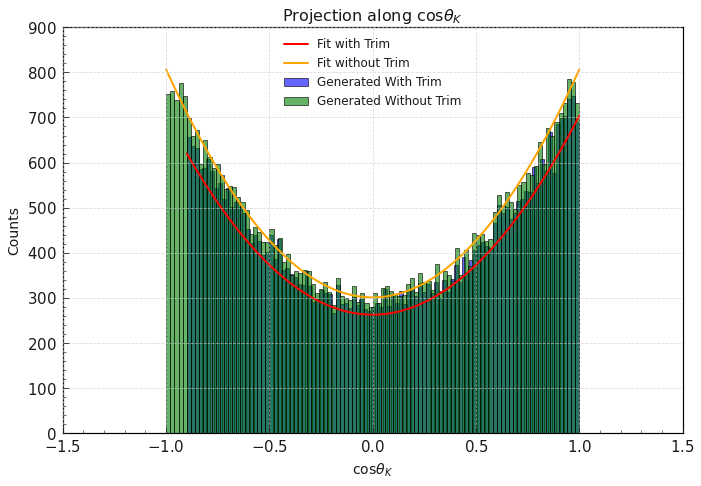

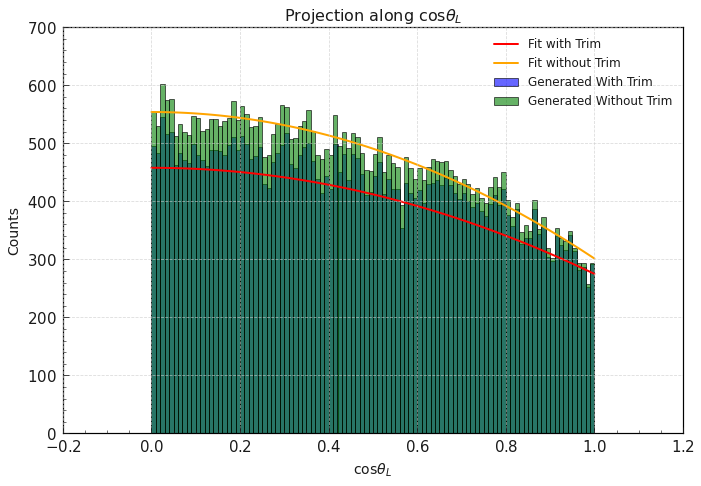

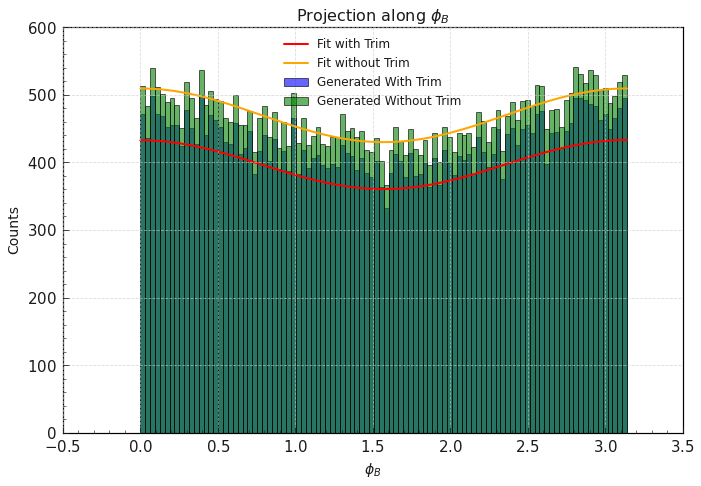

In [11]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt

def process_and_plot(mc_mu_signal_data_with_trim_fold, mc_mu_signal_data_without_trim_fold, pdf_fit_signal_with_trim_gr, pdf_fit_signal_without_trim_gr):
    # Define ranges
    cosTheta_K_range_with_trim = np.linspace(-0.9, 1.0, 100)  # Range for cosTheta_K with trim
    cosTheta_K_range_without_trim = np.linspace(-1.0, 1.0, 100)  # Range for cosTheta_K without trim
    cosTheta_L_range = np.linspace(0, 1.0, 100)
    phi_B_range = np.linspace(0, np.pi, 100)
    
    # Create grids for with trim
    cosTheta_K_grid_with_trim, cosTheta_L_grid, phi_B_grid = np.meshgrid(cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    points_with_trim = np.vstack([cosTheta_K_grid_with_trim.flatten(), cosTheta_L_grid.flatten(), phi_B_grid.flatten()]).T

    # Create grids for without trim
    cosTheta_K_grid_without_trim,cosTheta_L_grid_without_trim, phi_B_grid_without_trim= np.meshgrid(cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)
    points_without_trim = np.vstack([cosTheta_K_grid_without_trim.flatten(), cosTheta_L_grid_without_trim.flatten(), phi_B_grid_without_trim.flatten()]).T

        
    # PDF values without trim
    pdf_values_gr_without_trim = pdf_fit_signal_without_trim_gr.pdf(points_without_trim).numpy().reshape(cosTheta_K_grid_without_trim.shape)
    integrated_pdf_total_without_trim = simps(simps(simps(pdf_values_gr_without_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_without_trim, axis=0)
    
    # PDF values with trim
    pdf_values_gr_with_trim = pdf_fit_signal_without_trim_gr.pdf(points_with_trim).numpy().reshape(cosTheta_K_grid_with_trim.shape)
    integrated_pdf_total_with_trim = simps(simps(simps(pdf_values_gr_with_trim, phi_B_range, axis=2), cosTheta_L_range, axis=1), cosTheta_K_range_with_trim, axis=0)

    # Calculate proportion of data lost
    proportion_data_lost = (integrated_pdf_total_without_trim - integrated_pdf_total_with_trim) / integrated_pdf_total_without_trim

    # Print the integrated PDF
    print(f"Integrated PDF with trim: {integrated_pdf_total_with_trim}")
    print(f"Integrated PDF without trim: {integrated_pdf_total_without_trim}")
    print(f"Proportion of data lost: {proportion_data_lost:.4f}")
    
    
    # Integration and normalization steps
    def integrate_and_normalize(pdf_values, num_events, cosTheta_K_range, cosTheta_L_range, phi_B_range):
        integrated_pdf_values_K = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_L_range, axis=1)
        pdf_values_K = integrated_pdf_values_K * num_events * np.diff(cosTheta_K_range)[0] 

        integrated_pdf_values_L = simps(simps(pdf_values, phi_B_range, axis=2), cosTheta_K_range, axis=0)
        pdf_values_L = integrated_pdf_values_L * num_events * np.diff(cosTheta_L_range)[0] 

        integrated_pdf_values_B = simps(simps(pdf_values, cosTheta_K_range, axis=1), cosTheta_L_range, axis=0)
        pdf_values_B = integrated_pdf_values_B * num_events * np.diff(phi_B_range)[0] 

        return pdf_values_K, pdf_values_L, pdf_values_B

    pdf_values_K_with_trim, pdf_values_L_with_trim, pdf_values_B_with_trim = integrate_and_normalize(pdf_values_gr_with_trim, len(mc_mu_signal_data_with_trim_fold), cosTheta_K_range_with_trim, cosTheta_L_range, phi_B_range)
    pdf_values_K_without_trim, pdf_values_L_without_trim, pdf_values_B_without_trim = integrate_and_normalize(pdf_values_gr_without_trim, len(mc_mu_signal_data_without_trim_fold), cosTheta_K_range_without_trim, cosTheta_L_range, phi_B_range)

    # Plot results
    def plot_histogram_with_fit(data_with_trim, data_without_trim, range_with_trim, range_without_trim, pdf_values_with_trim, pdf_values_without_trim, var_name):
        plt.figure(figsize=(10, 7))

        # Plot histograms
        n_with_trim, bins_with_trim, _ = plt.hist(data_with_trim, bins=100, density=False, alpha=0.6, label='Generated With Trim', color='blue', edgecolor='black')
        n_without_trim, bins_without_trim, _ = plt.hist(data_without_trim, bins=100, density=False, alpha=0.6, label='Generated Without Trim', color='green', edgecolor='black')

        # Plot fit lines
        plt.plot(range_with_trim, pdf_values_with_trim, color='red', lw=2, label='Fit with Trim')
        plt.plot(range_without_trim, pdf_values_without_trim, color='orange', lw=2, label='Fit without Trim')

        # Set axis labels and title
        plt.xlabel(var_name, fontsize=14)
        plt.ylabel('Counts', fontsize=14)
        plt.title(f'Projection along {var_name}', fontsize=16)

        # Add legend
        plt.legend(loc='best', fontsize=12)

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Improve layout
        plt.tight_layout()

        # Show plot
        plt.savefig(f'generat_JPsi_{var_name}_muon.pdf')
        plt.show()
        

    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["cosTheta_K"], mc_mu_signal_data_without_trim_fold["cosTheta_K"], cosTheta_K_range_with_trim, cosTheta_K_range_without_trim, pdf_values_L_with_trim, pdf_values_L_without_trim, 'cos$\\theta_K$')
    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["cosTheta_L"], mc_mu_signal_data_without_trim_fold["cosTheta_L"], cosTheta_L_range, cosTheta_L_range, pdf_values_K_with_trim, pdf_values_K_without_trim, 'cos$\\theta_L$')
    plot_histogram_with_fit(mc_mu_signal_data_with_trim_fold["phi_B"], mc_mu_signal_data_without_trim_fold["phi_B"], phi_B_range, phi_B_range, pdf_values_B_with_trim, pdf_values_B_without_trim, '$\\phi_B$')


process_and_plot(mc_mu_signal_data_with_trim_fold, mc_mu_signal_data_without_trim_fold, pdf_fit_signal_with_trim_gr, pdf_fit_signal_without_trim_gr)
